[integral_pi_tanh] train_loss: 0.1198 | train_acc: 95.2% | val_loss: 0.1704 | val_acc: 93.3%
[scaled_tanh 1.3x] train_loss: 0.1144 | train_acc: 95.6% | val_loss: 0.1391 | val_acc: 94.3%
[plain_tanh] train_loss: 0.1221 | train_acc: 95.4% | val_loss: 0.1590 | val_acc: 92.9%


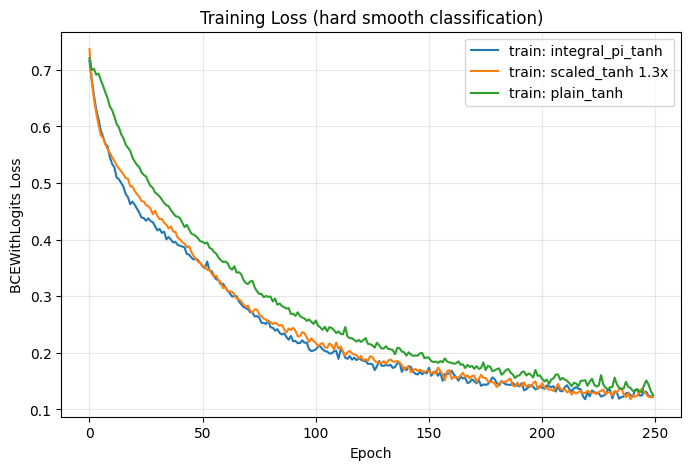

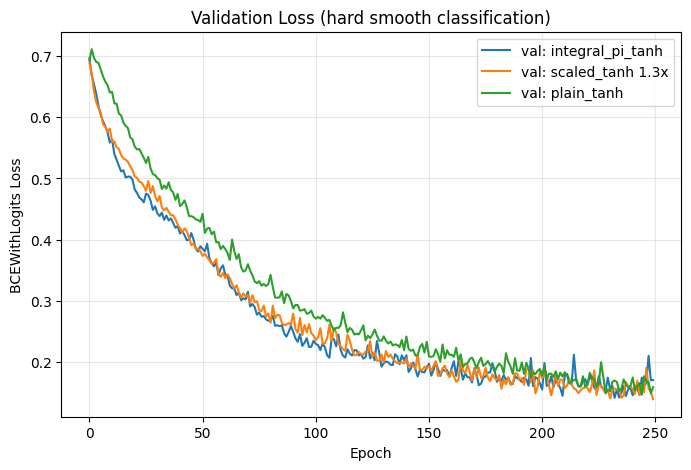

In [1]:
# Harder tanh-suited task + three activations: integral_pi_tanh, tanh(1.3x), and plain tanh
# Produces: two loss plots (train/val) and final metrics

import math
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import numpy as np
from typing import Callable, List, Tuple

# -----------------------
# Reproducibility
# -----------------------
torch.manual_seed(123)
np.random.seed(123)

device = torch.device("cpu")

# -----------------------
# Custom activations
# -----------------------
def integral_pi_tanh(s: torch.Tensor) -> torch.Tensor:
    """
    Torch version of:
        a = tanh(s)
        a2 = a*a
        out = (0.5 + (a/4) / (1 + (0.5*a2) / (1 + (1.5*a2) / (1 + 3*a2))) - 0.5) * (5 + 5/11)
    """
    a = torch.tanh(s)
    a2 = a * a
    denom = 1.0 + (0.5 * a2) / (1.0 + (1.5 * a2) / (1.0 + 3.0 * a2))
    out = (0.5 + (a / 4.0) / denom - 0.5) * (5.0 + 5.0 / 11.0)  # == ((a/4)/denom) * (60/11)
    return out

def integral_scaled_tanh(s: torch.Tensor) -> torch.Tensor:
    """tanh(1.3 * s)"""
    return torch.tanh(1.3 * s)

def plain_tanh(s: torch.Tensor) -> torch.Tensor:
    """tanh(s)"""
    return torch.tanh(s)

class Lambda(nn.Module):
    def __init__(self, fn: Callable[[torch.Tensor], torch.Tensor]):
        super().__init__()
        self.fn = fn
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return self.fn(x)

# -----------------------
# Harder dataset (smooth, tanh-friendly)
# y = 1 if sin(3x)*sin(3y) > 0 else 0
# -----------------------
def make_smooth_checkerboard(n_samples: int = 4096,
                             freq: float = 3.0,
                             input_range: float = math.pi,
                             noise_std: float = 0.15):
    # Sample in [-input_range, input_range]^2
    X = np.random.uniform(-input_range, input_range, size=(n_samples, 2)).astype(np.float32)
    # Add smooth input noise
    X += np.random.normal(0.0, noise_std, size=X.shape).astype(np.float32)
    # Labels: smooth periodic boundary
    y = (np.sin(freq * X[:, 0]) * np.sin(freq * X[:, 1]) > 0).astype(np.float32).reshape(-1, 1)
    return torch.tensor(X), torch.tensor(y)

X, y = make_smooth_checkerboard(n_samples=6000, freq=3.0, input_range=math.pi, noise_std=0.12)

# Train/val split
perm = torch.randperm(X.size(0))
split = int(0.8 * X.size(0))
idx_train = perm[:split]
idx_val   = perm[split:]

X_train, y_train = X[idx_train], y[idx_train]
X_val,   y_val   = X[idx_val],   y[idx_val]

# Standardize inputs (important for tanh)
mean = X_train.mean(dim=0, keepdim=True)
std  = X_train.std(dim=0, keepdim=True) + 1e-8
X_train = (X_train - mean) / std
X_val   = (X_val   - mean) / std

# -----------------------
# Model factory
# -----------------------
def make_mlp(activation_fn: Callable[[torch.Tensor], torch.Tensor],
             hidden_sizes=(64, 64, 64)) -> nn.Module:
    layers = []
    in_dim = 2
    for h in hidden_sizes:
        layers.append(nn.Linear(in_dim, h))
        layers.append(Lambda(activation_fn))
        in_dim = h
    layers.append(nn.Linear(in_dim, 1))  # logits
    model = nn.Sequential(*layers)
    # Xavier init tuned for tanh-like activations
    def init_weights(m):
        if isinstance(m, nn.Linear):
            gain = nn.init.calculate_gain('tanh')
            nn.init.xavier_uniform_(m.weight, gain=gain)
            if m.bias is not None:
                nn.init.zeros_(m.bias)
    model.apply(init_weights)
    return model

# -----------------------
# Training utilities
# -----------------------
def iterate_minibatches(X, y, batch_size=128, shuffle=True):
    N = X.size(0)
    indices = torch.arange(N)
    if shuffle:
        indices = indices[torch.randperm(N)]
    for start in range(0, N, batch_size):
        idx = indices[start:start+batch_size]
        yield X[idx], y[idx]

def train_model(model: nn.Module,
                X_train: torch.Tensor, y_train: torch.Tensor,
                X_val: torch.Tensor,   y_val: torch.Tensor,
                epochs: int = 200,
                lr: float = 2e-3,
                batch_size: int = 128,
                weight_decay: float = 1e-4):
    model.to(device)
    X_train = X_train.to(device)
    y_train = y_train.to(device)
    X_val   = X_val.to(device)
    y_val   = y_val.to(device)

    criterion = nn.BCEWithLogitsLoss()
    optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)

    train_losses, val_losses = [], []
    val_accs = []

    for epoch in range(epochs):
        model.train()
        epoch_loss = 0.0
        n_batches = 0
        for xb, yb in iterate_minibatches(X_train, y_train, batch_size=batch_size, shuffle=True):
            optimizer.zero_grad()
            logits = model(xb)
            loss = criterion(logits, yb)
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item()
            n_batches += 1
        train_losses.append(epoch_loss / max(n_batches, 1))

        # Validation
        model.eval()
        with torch.no_grad():
            logits_val = model(X_val)
            loss_val   = criterion(logits_val, y_val).item()
            probs_val  = torch.sigmoid(logits_val)
            preds_val  = (probs_val >= 0.5).float()
            acc_val    = (preds_val.eq(y_val).float().mean().item())
        val_losses.append(loss_val)
        val_accs.append(acc_val)

    # Final metrics
    model.eval()
    with torch.no_grad():
        logits_tr = model(X_train)
        tr_loss   = criterion(logits_tr, y_train).item()
        tr_acc    = (torch.sigmoid(logits_tr).ge(0.5).float().eq(y_train).float().mean().item())
        logits_v  = model(X_val)
        v_loss    = criterion(logits_v, y_val).item()
        v_acc     = (torch.sigmoid(logits_v).ge(0.5).float().eq(y_val).float().mean().item())

    return {
        "train_losses": train_losses,
        "val_losses": val_losses,
        "val_accs": val_accs,
        "final": {"train_loss": tr_loss, "train_acc": tr_acc, "val_loss": v_loss, "val_acc": v_acc},
        "model": model
    }

# -----------------------
# Build and train three models
# -----------------------
epochs = 250
hidden = (64, 64, 64)
common_args = dict(epochs=epochs, lr=2e-3, batch_size=128, weight_decay=1e-4)

mlp_pi     = make_mlp(integral_pi_tanh, hidden_sizes=hidden)
mlp_scaled = make_mlp(integral_scaled_tanh, hidden_sizes=hidden)
mlp_plain  = make_mlp(plain_tanh, hidden_sizes=hidden)

hist_pi     = train_model(mlp_pi,     X_train, y_train, X_val, y_val, **common_args)
hist_scaled = train_model(mlp_scaled, X_train, y_train, X_val, y_val, **common_args)
hist_plain  = train_model(mlp_plain,  X_train, y_train, X_val, y_val, **common_args)

# -----------------------
# Report metrics
# -----------------------
def fmt_final(tag, h):
    f = h["final"]
    print(f"[{tag}] train_loss: {f['train_loss']:.4f} | train_acc: {f['train_acc']*100:.1f}% "
          f"| val_loss: {f['val_loss']:.4f} | val_acc: {f['val_acc']*100:.1f}%")

fmt_final("integral_pi_tanh", hist_pi)
fmt_final("scaled_tanh 1.3x", hist_scaled)
fmt_final("plain_tanh",       hist_plain)

# -----------------------
# Plots: training and validation loss
# -----------------------
plt.figure(figsize=(8,5))
plt.plot(hist_pi["train_losses"],     label="train: integral_pi_tanh")
plt.plot(hist_scaled["train_losses"], label="train: scaled_tanh 1.3x")
plt.plot(hist_plain["train_losses"],  label="train: plain_tanh")
plt.title("Training Loss (hard smooth classification)")
plt.xlabel("Epoch")
plt.ylabel("BCEWithLogits Loss")
plt.grid(True, alpha=0.3)
plt.legend()
plt.show()

plt.figure(figsize=(8,5))
plt.plot(hist_pi["val_losses"],     label="val: integral_pi_tanh")
plt.plot(hist_scaled["val_losses"], label="val: scaled_tanh 1.3x")
plt.plot(hist_plain["val_losses"],  label="val: plain_tanh")
plt.title("Validation Loss (hard smooth classification)")
plt.xlabel("Epoch")
plt.ylabel("BCEWithLogits Loss")
plt.grid(True, alpha=0.3)
plt.legend()
plt.show()
